# Linearizing Flow: Baseline Tests

The purpose of this notebook is to explore and visualize different ways of establishing a linearizing flow, based from the MCR^2 framework

In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# import geoopt
import torch
# import itertools
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import tqdm

import scipy.io as spio
import open3d as o3d
import networkx
import imageio
import os
import re

import open3d as o3d

In [2]:
# dimension of data
d = 3
# number of samples
n = 100

In [3]:
# Set random seed
torch.manual_seed(42);

In [4]:
Z_0 = torch.randn(3,10)
Z_0 = Z_0 / np.sqrt(np.square(Z_0).sum(axis=0))
G = Z_0.t() @ Z_0
Z_1 = torch.randn(3,10)
Z_1 = Z_1 / np.sqrt(np.square(Z_1).sum(axis=0))
G_1 = Z_1.t() @ Z_1
# print(G)
# print(G_1 - G)
# print((G_1 - G)[G > 0])
print((G_1 - G)[G > 0].pow(2).sum())
# print(G > 0)

tensor(22.0121)


# Classes and Functions

In [102]:
# MAIN MODEL CODE
# Implemented as a PyTorch "NN" class, the "weights" here are
# the features Z, and the "forward pass" is the MCR^2 expansion term

# Built-in SGD component, tracks which part of the seed we are currently
# on

# One class, compression term only


class LinearizationFlow(nn.Module):

    def __init__(self, eps2, center, Z_0, K, delta, lambd):
        super(LinearizationFlow, self).__init__();
        # global vars init
        # dimension of data
        self.d = Z_0.shape[0];
        # number of data points
        self.n = Z_0.shape[1];
        # epsilon^2 parameter of MCR2 framework
        self.eps2 = eps2;
        # estimated max curvature of manifold underlying Z_0
        self.K = torch.tensor(K);
        # do we center data in loss computation?
        self.center = center;

        # Initialize features Z from given init Z_0
        self.Z = nn.Parameter(Z_0);
        # gram matrix of init
        self.gram_0 = Z_0.t() @ Z_0
        self.edm_0 = torch.diag(self.gram_0).reshape((n,1))@torch.ones((1,n)) \
            + torch.ones((n,1))@torch.diag(self.gram_0).reshape((1,n)) \
            - 2*self.gram_0
        # used for ReLU
        self.zeros = torch.zeros(self.edm_0.shape)

        # give an upper bound estimation on the initial RDM underlying Z_0
        edm_max = torch.max(self.edm_0)
        edm_min = torch.min(self.edm_0)
        # proper parameter for the exponential weighting
        alpha = torch.log(self.K) / (edm_max - edm_min)
        self.rdm_0 = self.edm_0*torch.exp(alpha*(self.edm_0 - edm_min))
        # observed indices for "close enough" points
        # self.Sigma = self.gram_0 > delta
        self.rdm_max = torch.max(self.rdm_0)
        self.delta = delta
        # amount regularization applies
        self.lambd = lambd

    def forward(self):

        if self.center:
            Zc = self.Z - torch.mean(self.Z, dim=1, keepdim=True);
        else:
            Zc = self.Z;
        # estimated covariance from samples
        C = (1/self.n)*Zc @ Zc.t();

        # mcr2 = torch.log(torch.det(torch.eye(self.d) + (self.d/self.eps2)*C)) + (self.d / (self.d+self.n))*torch.log(1 + torch.mean(self.Z, dim=1, keepdim=True).pow(2).sum()/self.eps2);
        mcr2 = torch.logdet(torch.eye(self.d) + (self.d/self.eps2)*C);
        # GRAM REGULARIZATIONS
        # metric_reg = 0.5*((self.Z.t()@self.Z - self.gram_0)*torch.exp(self.delta*(self.gram_0 - torch.ones(self.gram_0.shape)))).pow(2).sum()
        # metric_reg = torch.exp(self.delta*(self.gram_0 - torch.ones(self.gram_0.shape).pow(2))).sum()
        # metric_reg = 0.5*((self.Z.t()@self.Z - self.gram_0)).pow(2).sum()

        # EDM REGULARIZATIONS
        Z_gram = self.Z.t()@self.Z
        Z_EDM = torch.diag(Z_gram).reshape((n,1))@torch.ones((1,n)) \
            + torch.ones((n,1))@torch.diag(Z_gram).reshape((1,n)) \
            - 2*Z_gram

        # metric_reg = 0.5*((Z_EDM - self.edm_0)*torch.exp(-1*self.delta*(self.edm_0))).pow(2).sum()

        metric_reg = -1*(Z_EDM*(torch.exp(2*(self.rdm_0 - self.rdm_max)))).sum()
        # metric_reg = torch.log(torch.det(torch.eye(self.n) + self.delta*torch.max(self.rdm_0 - Z_EDM, self.zeros)))
        
        return mcr2 + self.lambd*metric_reg;
        # return self.lambd*metric_reg;

# # SGD component. NOTE: this does not update ALL data points at each GD update, just
# # the ones used for the stochastic gradient.
# class MCR2ExpansionSGD(nn.Module):

#     def __init__(self, batch_size, eps2, center, Z_0):
#         super(MCR2ExpansionSGD, self).__init__();
#         # global vars init
#         # dimension of data
#         self.d = Z_0.shape[0];
#         # number of data points
#         self.n = Z_0.shape[1];
#         self.batch_size = batch_size;
#         # epsilon^2 parameter of MCR2 framework
#         self.eps2 = eps2;
#         # do we center data in loss computation?
#         self.center = center;
#         # counter for sgd iterations
#         self.sgd_count = 0;
#         self.sgd_perm = torch.randperm(self.n);

#         # Initialize features Z from given init Z_0
#         self.Z = nn.Parameter(Z_0);

#     def forward(self):
#         # estimated second moments from samples
#         Z_sgd = self.Z[:,self.sgd_perm[self.sgd_count:self.sgd_count+self.batch_size]];
        
#         if self.center:
#             Zc = Z_sgd - torch.mean(Z_sgd, dim=1, keepdim=True);
#         else:
#             Zc = Z_sgd;

#         # refresh sgd count and perm if needed
#         self.sgd_count = (self.sgd_count + self.batch_size) % self.n;
#         # restart once end of data
#         if self.sgd_count == 0:
#             self.sgd_index = torch.randperm(self.n);

#         # estimated covariance from samples
#         C = (1/self.batch_size)*Zc @ Zc.t();
        
#         return -torch.log(torch.det(torch.eye(self.d) + (self.d/self.eps2)*C));

In [88]:
def experiment(LinFlow, lr, epochs, epoch_len, save=True, exp_name = ''):
    opt = optim.SGD(LinFlow.parameters(), lr=lr)

    # visualization stuff
    fig = plt.figure();
    ax = plt.axes(projection="3d")
    f.set_xlabel('X')
    f.set_ylabel('Y')
    f.set_zlabel('Z')
    Z_0 = LinFlow.Z.detach().clone().numpy()
    # to set the scale
    scatter = ax.scatter3D(Z_0[0,:], Z_0[1,:], Z_0[2,:], c='r', s = 6)

    # Uncomment to set the scale
    # ax.autoscale(False)
    images = []

    # create new directory for visualization

    #check if main directory has been made
    if not os.path.exists('./plots/'):
        os.mkdir('./plots/')
        os.mkdir('./plots/gifs/')
        os.mkdir('./plots/image_sequences/')

     # make plots directory if it doesnt exist
    file_num = -1
    for filename in os.listdir('./plots/image_sequences'):
        if '_' in filename:
            file_num_new = int(re.split('_|-', filename)[-2])
            if file_num_new > file_num:
                file_num = file_num_new
    os.mkdir(f'./plots/image_sequences/exp_{file_num+1}-{exp_name}')

    for i in range(epochs*epoch_len):
        LinFlow.zero_grad()
        # forward call of LinFlow
        loss = LinFlow()
            

        loss.backward()
        # GD step
        opt.step()
        # renormalization step
        with torch.no_grad():
            # normalize all features
        	# LinFlow.Z.data = LinFlow.Z.data / torch.sqrt(torch.square(LinFlow.Z.data).sum(axis=0));
            # normalize full Z-matrix
            # first mean-center
            LinFlow.Z.data = LinFlow.Z.data - torch.mean(LinFlow.Z.data, dim=1, keepdim=True);
            # then normalize, note doesnt destroy centering
            LinFlow.Z.data = LinFlow.Z.data * np.sqrt(n) / torch.sqrt(torch.square(LinFlow.Z.data).sum());
        
        # take a snapshot of frame to collect into GIF
        # Graph for initial distribution
        Z_np = LinFlow.Z.detach().clone().numpy();

        if (i % epoch_len == 0):
            print(f'epoch {i // epoch_len}: CR {loss}')
            # figure = plt.figure();
            # f = figure.add_subplot(111, projection='3d');
            if save:
                scatter.remove()

                scatter = ax.scatter3D(Z_np[0,:], Z_np[1,:], Z_np[2,:], c='r', s = 6)
                img_path = f'./plots/image_sequences/exp_{file_num+1}-{exp_name}/lin_flow_step{i}.jpg'
                plt.savefig(img_path)
                images.append(imageio.imread(img_path))

    print(f'Done with optimization! Final loss: {loss}')
    print('Saving gif...')
    # set the name for the next saved gif
    file_num = -1
    for filename in os.listdir('./plots/gifs'):
        if '_' in filename:
            file_num_new = int(re.split('_|\.|-', filename)[-3])
            if file_num_new > file_num:
                file_num = file_num_new
    imageio.mimsave(f'plots/gifs/gif_{file_num + 1}-{exp_name}.gif', images)
    print('Done!')


In [39]:
hi = torch.randn(3,3)
print(hi)
zeros = torch.zeros(hi.shape)
print(torch.max(hi, zeros))

tensor([[ 0.3415, -0.0716, -0.0909],
        [-1.3297, -0.5426,  0.5471],
        [ 0.6431, -0.7905, -0.9058]])
tensor([[0.3415, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5471],
        [0.6431, 0.0000, 0.0000]])


# Run Test
Below code is where to specify what test to run

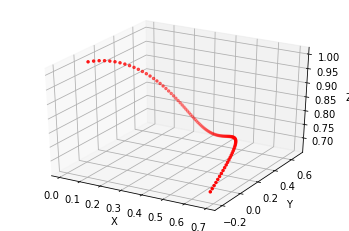

10.0


In [42]:
##################### VISUALIZE INIT DATA ##################

# projected sin wave
Z_0 = np.zeros((d,n))
for i in range(n):
	Z_0[0,i] = (i+1)/n;
	Z_0[1,i] = np.sin((i+1)/n*1.1*np.pi);
	Z_0[2,i] = 1;


# required normalization
Z_0 = Z_0 / np.sqrt(np.square(Z_0).sum(axis=0));

figure = plt.figure()
f = figure.add_subplot(111, projection='3d')

f.scatter(Z_0[0,:], Z_0[1,:], Z_0[2,:], c='r', s = 6)

f.set_xlabel('X')
f.set_ylabel('Y')
f.set_zlabel('Z')

plt.show()

print( np.sqrt(np.square(Z_0).sum()))


epoch 0: CR 6.995626449584961
epoch 1: CR -42.93159866333008
epoch 2: CR -44.52378845214844
epoch 3: CR -46.106544494628906
epoch 4: CR -47.683021545410156
epoch 5: CR -49.26105499267578
epoch 6: CR -50.85783386230469
epoch 7: CR -52.51264190673828
epoch 8: CR -54.337615966796875
epoch 9: CR -56.9658203125
epoch 10: CR -60.72904968261719
epoch 11: CR -61.752986907958984
epoch 12: CR -62.73870849609375
epoch 13: CR -63.68722152709961
epoch 14: CR -64.60131072998047
epoch 15: CR -65.48290252685547
epoch 16: CR -66.33525085449219
epoch 17: CR -67.16212463378906
epoch 18: CR -67.96826934814453
epoch 19: CR -68.76087951660156
epoch 20: CR -69.54995727539062
epoch 21: CR -70.3511734008789
epoch 22: CR -71.19386291503906
epoch 23: CR -72.14374542236328
epoch 24: CR -73.4282455444336
epoch 25: CR -77.46773529052734
epoch 26: CR -77.75298309326172
epoch 27: CR -78.0228500366211
epoch 28: CR -78.27925872802734
epoch 29: CR -78.52204132080078
epoch 30: CR -78.75236511230469
epoch 31: CR -78.97066

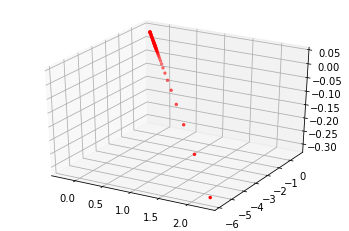

In [103]:
############################## RUN EXPERIMENT ##############w
Z_0 = np.zeros((d,n))
for i in range(n):
	Z_0[0,i] = (i+1)/n;
	Z_0[1,i] = np.sin((i+1)/n*1.3*np.pi);
	Z_0[2,i] = 1;


# required normalization
Z_0 = Z_0 / np.sqrt(np.square(Z_0).sum(axis=0));
Z_0 = torch.from_numpy(Z_0).float();

LinFlow = LinearizationFlow(eps2=0.0001, center=True, Z_0=Z_0, K=1, delta=1, lambd=0.01)

experiment(LinFlow, lr=0.002, epochs = 150, epoch_len = 20, exp_name='together')
# make gif and organize generated images
# !python3 stitch_jpgs.py


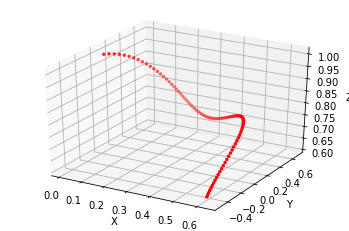

In [62]:
# Graph for initial distribution
figure = plt.figure()
f = figure.add_subplot(111, projection='3d')

f.scatter(Z_0[0,:], Z_0[1,:], Z_0[2,:], c='r', s = 6)

f.set_xlabel('X')
f.set_ylabel('Y')
f.set_zlabel('Z')

plt.show()

In [65]:
print(Z_0.shape)

torch.Size([3, 100])


In [67]:
print(torch.sum(torch.pow(Z_0 - Z_0[:,0].reshape((3,1)), 2), axis=0))

tensor([0.0000, 0.0017, 0.0069, 0.0153, 0.0267, 0.0409, 0.0575, 0.0763, 0.0968,
        0.1187, 0.1417, 0.1655, 0.1897, 0.2142, 0.2387, 0.2629, 0.2867, 0.3100,
        0.3325, 0.3543, 0.3752, 0.3952, 0.4142, 0.4322, 0.4491, 0.4650, 0.4798,
        0.4935, 0.5061, 0.5176, 0.5281, 0.5375, 0.5459, 0.5532, 0.5595, 0.5648,
        0.5691, 0.5724, 0.5748, 0.5762, 0.5767, 0.5762, 0.5749, 0.5727, 0.5696,
        0.5658, 0.5610, 0.5556, 0.5493, 0.5424, 0.5348, 0.5266, 0.5178, 0.5085,
        0.4987, 0.4886, 0.4782, 0.4676, 0.4569, 0.4463, 0.4358, 0.4256, 0.4159,
        0.4068, 0.3984, 0.3908, 0.3844, 0.3791, 0.3752, 0.3728, 0.3719, 0.3727,
        0.3752, 0.3795, 0.3856, 0.3934, 0.4030, 0.4141, 0.4268, 0.4409, 0.4563,
        0.4728, 0.4902, 0.5084, 0.5273, 0.5466, 0.5662, 0.5860, 0.6059, 0.6256,
        0.6451, 0.6644, 0.6832, 0.7016, 0.7195, 0.7368, 0.7535, 0.7695, 0.7849,
        0.7995])


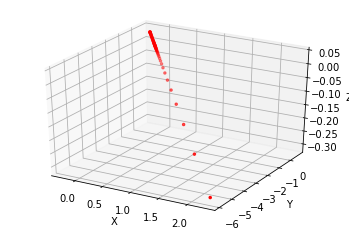

[1.0000000e+01 2.2573248e-07 2.1196495e-08]


In [105]:
# Graph for final distribution
figure = plt.figure()
f = figure.add_subplot(111, projection='3d')
Z_np = LinFlow.Z.detach().clone().numpy();

f.scatter(Z_np[0,:], Z_np[1,:], Z_np[2,:], c='r', s = 6)

f.set_xlabel('X')
f.set_ylabel('Y')
f.set_zlabel('Z')

plt.show()

u, s, v = np.linalg.svd(Z_np)
print(s)

In [79]:
pointclud = Z_np.T
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pointclud)
o3d.visualization.draw_geometries([pcd])

In [49]:
u, s, v = np.linalg.svd(Z_np)
print(s)

[1.0000000e+01 3.9621219e-07 4.9564083e-08]


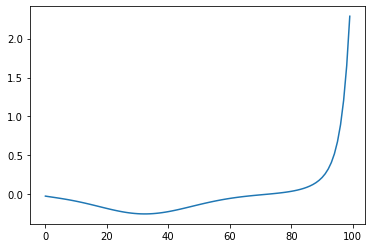

In [109]:
plt.plot(np.arange(100),Z_np[0,:])